In [ ]:
# This notebook's pipeline is managed through mrxlinx extension.
# Looks like it's not organized, but in this extension shows 
# the whole pipeline correctly.

In [4]:
import pandas as pd
import numpy as np
import polars as pl
from pickle import dump, load
import itertools
import winsound

import Custom_Tools
from sksurv.nonparametric import kaplan_meier_estimator
from target_definition_polars import target_definition_polars
from drop_turnover import drop_turnover
from preprocess_turnover import preprocess_turnover
from scale_dataset import scale_dataset
from final_transformation import final_transformation


from sklearn.model_selection import train_test_split, StratifiedKFold, ShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif


from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics

import optuna

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import shap




In [5]:
pl.Float64

Float64

In [ ]:
path = 'C:/Users/Gabriel.Gomes/Downloads/Turnover/23-01-16/'

In [ ]:
df_pd = pd.read_excel(path + 'Análise_Headcount.xlsx')
df_pd.astype(str).to_parquet(path + 'Análise_Headcount.parquet', index=False)

df_mov_pd = pd.read_excel(path + 'Movimentações.xlsx')
df_mov_pd['dtmudanca'] = df_mov_pd.dtmudanca.dt.date
df_mov_pd = df_mov_pd[df_mov_pd.descricao.isin(['MÉRITO', 'PROMOÇÃO'])]
df_mov_pd.astype(str).to_parquet(path + 'Movimentações.parquet', index=False)


duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)

In [ ]:
df = pl.read_parquet(path + 'Análise_Headcount.parquet')
df_mov = pl.read_parquet(path + 'Movimentações.parquet')

'''
Adicionar tipo de função (Gestor, não gestor)
Salário, méritos e promoções
Pulses


'''

In [ ]:
df.columns

In [ ]:
# Needs to be fixed, target_definition is excluding more than 1 year dismissals

df_surv = target_definition(df, 'tipo_colaborador', 'CLT')
df_surv = df_surv[(df_surv.tempo_de_casa > 0) & (df_surv.tempo_de_casa < 62)]
df_surv.loc[df_surv.tipo_função == 'Docente','tipo_filial'] = 'DOCENTE'

In [ ]:
df_surv.cod

In [ ]:
fig = px.histogram(df_surv, x="tempo_de_casa",  color="desligado", facet_col="corraca_descricao", facet_row="escolaridade_classificação",height=1500, width = 1000) # noqa E501
fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

for annotation in fig['layout']['annotations']: 
    annotation['textangle']= 25
fig.show()

In [ ]:
g = sns.FacetGrid(data=df_surv, row="escolaridade_classificação", col="corraca_descricao", hue = 'desligado')


g.map(sns.kdeplot, "tempo_de_casa", warn_singular=False);






In [ ]:
data_x = df_surv.copy()

data_y = df_surv.desligado==1

surv_days = data_x.tempo_de_casa

analyze = ['tipo_filial','VP_descricao','genero', 'corraca_descricao']

for i in analyze:

    analisar = i

    plt.figure(figsize=(12, 12), dpi=80)

    for value in data_x[analisar].unique():
        mask = data_x[analisar] == value
        time_cell, survival_prob_cell = kaplan_meier_estimator(data_y[mask],
                                                               surv_days[mask])
        plt.step(time_cell, survival_prob_cell, where="post",
                 label="%s (n = %d)" % (value, mask.sum()));

    plt.ylabel("est. probability of survival $\hat{S}(t)$")
    plt.xlabel("Months")
    plt.legend(loc="best");


In [1]:
df_alvo = target_definition_polars(df, df_mov, 'tipo_colaborador', 'CLT')

C:\Users\Gabriel.Gomes\OneDrive\Documents\GitHub\Turnover\feature_engineering_polars.py:76: RuntimeWarning: divide by zero encountered in true_divide
  df_origin[col + '_proportion_contagion'] = np.nan_to_num(np.ndarray.round(np.array(col_contagion) / np.array(group_contagion),2))
C:\Users\Gabriel.Gomes\OneDrive\Documents\GitHub\Turnover\feature_engineering_polars.py:76: RuntimeWarning: invalid value encountered in true_divide
  df_origin[col + '_proportion_contagion'] = np.nan_to_num(np.ndarray.round(np.array(col_contagion) / np.array(group_contagion),2))
C:\Users\Gabriel.Gomes\OneDrive\Documents\GitHub\Turnover\feature_engineering_polars.py:76: RuntimeWarning: divide by zero encountered in true_divide
  df_origin[col + '_proportion_contagion'] = np.nan_to_num(np.ndarray.round(np.array(col_contagion) / np.array(group_contagion),2))
C:\Users\Gabriel.Gomes\OneDrive\Documents\GitHub\Turnover\feature_engineering_polars.py:76: RuntimeWarning: invalid value encountered in true_divide
  df_o

codcoligada
<class 'str'>
codsecao
<class 'str'>
dataadmissao
<class 'str'>
datademissao
<class 'str'>
codpessoa
<class 'str'>
nome
<class 'str'>
chave_coligada_chapa
<class 'str'>
filial_cidade
<class 'str'>
filial_estado
<class 'str'>
codsindicato
<class 'str'>
faixa_tempo_casa
<class 'str'>
tempo_casa_anos
<class 'str'>
residencia_cidade
<class 'str'>
residencia_estado
<class 'str'>
escolaridade_descricao
<class 'str'>
corraca_descricao
<class 'str'>
idade
<class 'str'>
faixa_etaria
<class 'str'>
genero
<class 'str'>
ord_faixa_tempo_casa
<class 'str'>
ord_faixa_etaria
<class 'str'>
Residência
<class 'str'>
Filial
<class 'str'>
nome_sindicato
<class 'str'>
nome_sindicato_abreviado
<class 'str'>
escolaridade_faixas
<class 'str'>
escolaridade_classificação
<class 'str'>
tipo_colaborador_bertelsmann
<class 'str'>
VP
<class 'str'>
integrada
<class 'str'>
raiz_vp
<class 'str'>
filial_descricao
<class 'str'>
setor
<class 'str'>
funcao_descricao
<class 'str'>
VP_descricao
<class 'str'>
situ

In [ ]:
X, X_holdout, y, y_holdout = train_test_split(df_alvo.drop(['desligado'], axis=1), df_alvo['desligado'], test_size=0.1, random_state=42, stratify=df_alvo['desligado']) # noqa E501

In [ ]:
print(y.value_counts()/y.shape[0])
print(y_holdout.value_counts()/y_holdout.shape[0])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # noqa E501

df_trat = X_train

y_trat = y_train.loc[df_trat.index]



In [ ]:
print(y_train.value_counts()/y_train.shape[0])
print(y_test.value_counts()/y_test.shape[0])

In [ ]:
print(X_train.idade.mean())

In [1]:
df_trat_drop = drop_turnover(df_trat)

df_preprocess = preprocess_turnover(df_trat_drop)

In [2]:
teste = df_trat_drop.copy()

for i in teste:
    print(f'{i} - {teste[i].dtype}')

corraca_descricao - object
idade - int16
genero - int64
ord_faixa_tempo_casa - int8
ord_faixa_etaria - int8
escolaridade_classificação - int64
filial_descricao - object
VP_descricao - object
salario - float64
tipo_filial - object
cotapcd - int8
tempo_de_casa - float32
codsecao_gerencia_contagion - int32
codsecao_gerencia_proportion_contagion - float64
funcao_descricao_clean_contagion - int32
funcao_descricao_clean_proportion_contagion - float64
engineer_promotion_indexes - float32
engineer_merit_indexes - float32


In [3]:
print(df_preprocess.columns)
print(df_preprocess.shape)
print(y_trat.shape)
#print(pd.cut(df_trat_drop.salario, [0,5000,10000,15000,20000]).value_counts()/df_trat_drop.shape[0])
print(df_preprocess.isnull().sum())

duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)


Index(['idade', 'genero', 'ord_faixa_tempo_casa', 'ord_faixa_etaria',
       'escolaridade_classificao', 'salario', 'cotapcd', 'tempo_de_casa',
       'codsecao_gerencia_contagion', 'codsecao_gerencia_proportion_contagion',
       'funcao_descricao_clean_contagion',
       'funcao_descricao_clean_proportion_contagion',
       'engineer_promotion_indexes', 'engineer_merit_indexes',
       'corraca_descricao_Amarela', 'corraca_descricao_Branca',
       'corraca_descricao_Indgena', 'corraca_descricao_Parda',
       'corraca_descricao_Preta', 'filial_descricao_AFYA',
       'filial_descricao_AFYASP', 'filial_descricao_IPEMED',
       'filial_descricao_MEDCELEDITORAEEVENTOSSA', 'filial_descricao_PEBMED',
       'VP_descricao_AUDITORIAINTERNA', 'VP_descricao_CEO',
       'VP_descricao_DIRETORIAJURIDICOECOMPLIANCE',
       'VP_descricao_VICEPRESIDENCIADEGENTEGESTAOESERVICOS',
       'VP_descricao_VICEPRESIDENCIADEINOVACAOESERVDIGITAIS',
       'VP_descricao_VICEPRESIDENCIADEINOVACAOETECNOLOGI

In [ ]:
df_preprocess.columns

In [42]:
Scaler = MinMaxScaler((0,1))
Scaler.fit(df_preprocess[feature_final])
dump(Scaler, open('Scaler.pkl', 'wb'))

In [ ]:
df_eng.loc[df_eng.filial_descricao.str.contains('IPEMED'), 'filial_descricao'] = 'IPEMED'

df_eng.filial_descricao.unique()

In [ ]:
df_eng.filial_descricao.unique()

In [ ]:
from sklearn.feature_extraction import FeatureHasher

def useful_metrics(X_df, y_df, model, threshold=0.5):
    evaluation = {}
    
    results = model.predict_proba(X_df)[:,-1]>threshold

    base_metrics = [
                metrics.f1_score,
                metrics.recall_score,
                metrics.precision_score,
                metrics.brier_score_loss]

    for metric in base_metrics:
            
        if metric.__name__ == 'brier_score_loss':
        
            evaluation[metric.__name__] = round(metric(y_df, model.predict_proba(X_df)[:,-1]),2)
        
        else:
            
            evaluation[metric.__name__] = round(metric(y_df, results, zero_division=0),2)

    return pd.DataFrame(evaluation, index=[0])





def feature_hashing_optimum(col_name, final_number_of_columns = 0):
    
    from tqdm.notebook import tqdm
    
    scores = pd.DataFrame()
    
    if final_number_of_columns == 0:

        for i in tqdm(range(3,20)):

            n_features = i

            hashf = FeatureHasher(n_features=n_features,  input_type='string')

            cols = ['Test_'+str(i) for i in range(n_features)]

            train_hash = pd.DataFrame(hashf.fit_transform(df_trat[col_name]).toarray(), columns = cols )

            test_hash = pd.DataFrame(hashf.transform(X_test[col_name]).toarray(), columns = cols)

            model = XGBClassifier(use_label_encoder=False, verbosity=0)

            model.fit(train_hash, y_trat)

            score = useful_metrics(test_hash, y_test, model)

            score['cols'] = i

            scores = pd.concat([scores, score])

        return scores

    else:

        hashf = FeatureHasher(n_features=final_number_of_columns,  input_type='string')
        hashf.fit(df_trat[col_name])

        return hashf



In [ ]:
final_score = feature_hashing_optimum('codsecao')
final_score
scores_trat = final_score.copy() 
scores_trat.index = scores_trat.cols
scores_trat[['f1_score', 'recall_score', 'precision_score']].plot(figsize=(10, 6))

In [ ]:
df_trat.columns

In [ ]:
scores_trat['score'] = scores_trat.cols*3 - scores_trat.f1_score*200

scores_trat.sort_values('score')

In [ ]:
a = feature_hashing_optimum('codsecao', 11)

In [ ]:
a.fit_transform(df_trat['codsecao']).toarray()

In [ ]:
dump(feature_hashing_optimum('codsecao', 11),
     open('codsecao_hasher.pkl', 'wb'))

In [ ]:
tt.columns

In [ ]:
def feature_hashing(df, col_name, hasher):

    cols = [col_name+'_'+str(i) for i in range(hasher.get_params()['n_features'])]

    return  pd.concat([df, pd.DataFrame(hasher.transform(df[col_name]).toarray(), columns = cols, index=df.index)], axis=1)

In [ ]:
pd.DataFrame()

In [ ]:

a = feature_hashing(df_trat, 'codsecao', hasher1)
a

In [22]:
Scaler = load(open('Scaler.pkl', 'rb'))
feature_final = load(open('feature_selection.pkl', 'rb'))
#feature_final = df_preprocess.columns.tolist()
scaled_df = df_preprocess[feature_final]
scaled_df = scale_dataset(df_preprocess, feature_final, Scaler)

In [ ]:
df_preprocess.columns

In [ ]:
df_preprocess_analysis = scaled_df.copy()
df_preprocess_analysis['desligado'] = y_train

aval = Custom_Tools.preprocess_afya(df_preprocess_analysis)

cols = aval.col_missing()

card = aval.cardinality()

rws = aval.row_missing()

In [ ]:
print(rws[rws > 0])

In [ ]:
print(cols[cols > 0])

In [ ]:
cols = df_preprocess_analysis.columns.tolist()

In [ ]:
cols.remove('desligado')

In [ ]:
aval.distribution(cols, 'desligado')

# Feature Selection

In [ ]:
y_trat.shape

In [13]:
df_preprocess.iloc[:,11]

932      0.000000e+00
993     2.781342e-310
732     5.006416e-310
148      0.000000e+00
968      0.000000e+00
            ...      
1142    3.893879e-310
624      0.000000e+00
674      0.000000e+00
495      0.000000e+00
575      0.000000e+00
Name: funcao_descricao_clean_proportion_contagion, Length: 1030, dtype: float64

In [11]:
feature_check = [x for x in df_preprocess.columns]
algorithms = [chi2, f_classif, mutual_info_classif]
selection = Custom_Tools.feature_selection(df_preprocess[feature_check], y_trat, algorithms, 500)


  0%|          | 0/500 [00:00<?, ?it/s]

In [13]:
features = selection.columns.tolist()
features.remove('Total_points')
Kbest_eval = selection.groupby('Columns').sum()['Total_points'].sort_values(ascending=False) # noqa E501
Kbest_eval

Columns
codsecao_gerencia_contagion                            1500
tempo_de_casa                                          1500
codsecao_gerencia_proportion_contagion                 1500
ord_faixa_tempo_casa                                   1500
VP_descricao_VICEPRESIDENCIADEMERCADO                  1355
funcao_descricao_clean_contagion                       1226
idade                                                  1202
filial_descricao_MEDCELEDITORAEEVENTOSSA               1060
VP_descricao_VICEPRESIDENCIADEINOVACAOETECNOLOGIA      1056
engineer_promotion_indexes                             1000
engineer_merit_indexes                                 1000
salario                                                 979
ord_faixa_etaria                                        573
genero                                                  563
filial_descricao_AFYA                                   558
funcao_descricao_clean_proportion_contagion             499
VP_descricao_VICEPRESIDENCIADEOP

In [15]:
Kbest_eval[(Kbest_eval/Kbest_eval[0])>0.3].index.tolist()

['codsecao_gerencia_contagion',
 'tempo_de_casa',
 'codsecao_gerencia_proportion_contagion',
 'ord_faixa_tempo_casa',
 'VP_descricao_VICEPRESIDENCIADEMERCADO',
 'funcao_descricao_clean_contagion',
 'idade',
 'filial_descricao_MEDCELEDITORAEEVENTOSSA',
 'VP_descricao_VICEPRESIDENCIADEINOVACAOETECNOLOGIA',
 'engineer_promotion_indexes',
 'engineer_merit_indexes',
 'salario',
 'ord_faixa_etaria',
 'genero',
 'filial_descricao_AFYA',
 'funcao_descricao_clean_proportion_contagion']

In [81]:
# Tempo de casa redundante com ord_faixa_tempo_casa
feature_final = ['tipo_filial_DIGITAL', 'filial_descricao_AFYA',
       'genero',
       'engineer_merit_indexes',
       'codsecao_gerencia_contagion',
       'salario', 'funcao_descricao_clean_contagion',
       'tempo_de_casa', 'engineer_promotion_indexes']

#feature_final = df_preprocess.columns

dump(feature_final, open('feature_selection.pkl', 'wb'))

In [42]:
Scaler = load(open('Scaler.pkl', 'rb'))
feature_final = load(open('feature_selection.pkl', 'rb'))
#feature_final = df_preprocess.columns.tolist()
scaled_df = df_preprocess[feature_final].copy()
scaled_df = scale_dataset(df_preprocess, feature_final, None)


# Comment if feature selection was used
# dump(feature_final, open('feature_selection.pkl', 'wb'))

X_train_final = scaled_df[feature_final].copy()

In [96]:
feature_final

Index(['idade', 'genero', 'ord_faixa_tempo_casa', 'ord_faixa_etaria',
       'escolaridade_classificao', 'salario', 'cotapcd', 'tempo_de_casa',
       'codsecao_gerencia_contagion', 'codsecao_gerencia_proportion_contagion',
       'funcao_descricao_clean_contagion',
       'funcao_descricao_clean_proportion_contagion',
       'engineer_promotion_indexes', 'engineer_merit_indexes',
       'corraca_descricao_Amarela', 'corraca_descricao_Branca',
       'corraca_descricao_Indgena', 'corraca_descricao_Parda',
       'corraca_descricao_Preta', 'filial_descricao_AFYA',
       'filial_descricao_AFYASP', 'filial_descricao_IPEMED',
       'filial_descricao_MEDCELEDITORAEEVENTOSSA', 'filial_descricao_PEBMED',
       'VP_descricao_AUDITORIAINTERNA', 'VP_descricao_CEO',
       'VP_descricao_DIRETORIAJURIDICOECOMPLIANCE',
       'VP_descricao_VICEPRESIDENCIADEGENTEGESTAOESERVICOS',
       'VP_descricao_VICEPRESIDENCIADEINOVACAOESERVDIGITAIS',
       'VP_descricao_VICEPRESIDENCIADEINOVACAOETECNOLOGI

In [ ]:
lr = LogisticRegression(max_iter=10000)
lgbm = LGBMClassifier()
gnb = GaussianNB()


models = {'Logistic Regression': lr,
          'LGBM': lgbm,
          'Gaussian NB': gnb,
          'Random Forest | Default': RandomForestClassifier()}

for a in range(5, 3, -1):
    models['Random Forest - Max_depth:'+str(a)] = RandomForestClassifier(max_depth=a) # noqa E501


In [ ]:
models_1 = {'Random Forest - Default': RandomForestClassifier()}

In [ ]:
test = Custom_Tools.overfit(X_train_final, y_trat, models_1, None, None)
test_results = test.overfit(metrics.f1_score)
test_results

In [ ]:
fig = px.line(test_results, x="Sample", y="f1_score", color="Dataset", facet_col="Model", facet_col_wrap=4, height=500, range_y=[0,1]) # noqa E501
fig.show()

In [26]:
All_models_f1 = Custom_Tools.overfit(X_train_final, y_trat, models, None, None)
All_models_results_f1 = All_models_f1.overfit(metrics.f1_score)
All_models_f1 = Custom_Tools.overfit(X_train_final, y_trat, models, None, ADASYN(sampling_strategy= 1.0)) # noqa E501
All_models_results_f1 = pd.concat([All_models_results_f1, All_models_f1.overfit(metrics.f1_score)]) # noqa E501


Amount of sample fitted and predicted on train set: 144
Amount of sample predicted on test set: 61
Sample 20% generated 

Logistic Regression: 0 seconds
LGBM: 0 seconds
Gaussian NB: 0 seconds
Random Forest | Default: 0 seconds
Random Forest - Max_depth:5: 0 seconds
Random Forest - Max_depth:4: 0 seconds

Total sample training time: 0 seconds


Amount of sample fitted and predicted on train set: 288
Amount of sample predicted on test set: 123
Sample 40% generated 

Logistic Regression: 0 seconds
LGBM: 0 seconds
Gaussian NB: 0 seconds
Random Forest | Default: 0 seconds
Random Forest - Max_depth:5: 0 seconds
Random Forest - Max_depth:4: 0 seconds

Total sample training time: 0 seconds


Amount of sample fitted and predicted on train set: 432
Amount of sample predicted on test set: 185
Sample 60% generated 

Logistic Regression: 0 seconds
LGBM: 0 seconds
Gaussian NB: 0 seconds
Random Forest | Default: 0 seconds
Random Forest - Max_depth:5: 0 seconds
Random Forest - Max_depth:4: 0 seconds


In [29]:
pivot_f1 = All_models_results_f1.pivot(index=['Sample', 'Model'], columns='Dataset', values='f1_score') # noqa E501
pivot_f1['Overfit'] = abs(pivot_f1['Test']-pivot_f1['Train'])
pivot_f1 = pivot_f1.groupby(['Model'])[['Overfit', 'Test']].mean().sort_values(['Overfit']) # noqa E501
pivot_f1[pivot_f1.Test > 0]

Dataset,Overfit,Test
Model,,
Gaussian NB,0.093712,0.326360
Logistic Regression,0.130270,0.175050
Random Forest - Max_depth:5,0.137548,0.556435
Random Forest - Max_depth:4,0.142976,0.526247
Logistic Regression - ADASYN,0.346865,0.377680
Gaussian NB - ADASYN,0.354814,0.325404
Random Forest - Max_depth:4 - ADASYN,0.398969,0.478287
Random Forest - Max_depth:5 - ADASYN,0.426661,0.477932
Random Forest | Default,0.452410,0.547590


In [ ]:
All_models_recall = Custom_Tools.overfit(X_train_final, y_trat, models, None, None) # noqa E501
All_models_results_recall = All_models_recall.overfit(metrics.recall_score)
All_models_recall = Custom_Tools.overfit(X_train_final, y_trat, models, None, ADASYN(sampling_strategy= 1.0)) # noqa E501
All_models_results_recall = pd.concat([All_models_results_recall, All_models_recall.overfit(metrics.recall_score)]) # noqa E501

In [ ]:
All_models_recall = Custom_Tools.overfit(X_train_final, y_trat, models, None, None) # noqa E501
All_models_results_recall = All_models_recall.overfit(metrics.recall_score)
All_models_recall = Custom_Tools.overfit(X_train_final, y_trat, models, None, ADASYN(sampling_strategy= 1.0)) # noqa E501
All_models_results_recall = pd.concat([All_models_results_recall, All_models_recall.overfit(metrics.recall_score)]) # noqa E501

In [ ]:
pivot_recall = All_models_results_recall.pivot(index=['Sample', 'Model'], columns='Dataset', values='recall_score') # noqa E501
pivot_recall['Overfit'] = abs(pivot_recall['Test']-pivot_recall['Train'])
pivot_recall = pivot_recall.groupby('Model')['Overfit', 'Test'].mean().sort_values('Overfit') # noqa E501
pivot_recall[pivot_recall.Test > 0]

In [ ]:
All_models_precision = Custom_Tools.overfit(X_train_final, y_trat, models, None, None) # noqa E501
All_models_results_precision = All_models_precision.overfit(metrics.f1_score)
All_models_precision = Custom_Tools.overfit(X_train_final, y_trat, models, None, ADASYN(sampling_strategy= 1.0)) # noqa E501
All_models_results_precision = pd.concat([All_models_results_precision, All_models_precision.overfit(metrics.precision_score)]) # noqa E501


In [ ]:
pivot_precision = All_models_results_precision.pivot(index=['Sample', 'Model'], columns='Dataset', values='precision_score') # noqa E501
pivot_precision['Overfit'] = abs(pivot_precision['Test']-pivot_precision['Train'])
pivot_precision = pivot_precision.groupby('Model')[['Overfit', 'Test']].mean().sort_values('Overfit') # noqa E501
pivot_precision[pivot_precision.Test > 0]

In [ ]:
fig = px.line(All_models_results_f1, x="Sample", y="f1_score",color="Dataset",facet_col="Model",facet_col_wrap=4, height=2500,range_y=[0,1]) # noqa E501
fig.show()

In [44]:
X_test_final = final_transformation(X_test, feature_final, 0, None)

In [45]:
X_test_final.columns

Index(['tipo_filial_DIGITAL', 'VP_descricao_VICEPRESIDENCIADESERVICOSDIGITAIS',
       'filial_descricao_AFYA', 'VP_descricao_VICEPRESIDENCIADEMERCADO',
       'genero', 'VP_descricao_VICEPRESIDENCIADEINOVACAOESERVDIGITAIS',
       'engineer_merit_indexes', 'codsecao_gerencia_contagion', 'salario',
       'funcao_descricao_clean_contagion', 'tempo_de_casa',
       'engineer_promotion_indexes'],
      dtype='object')

In [ ]:
X_train_final, y_train_final = X_train_final, y_trat

In [ ]:
print(X_train_final.shape)
print(y_train_final.shape)
print(X_test_final.shape)
print(y_test.shape)

In [ ]:
def useful_metrics(X_df, y_df, model, threshold=0.5):
    evaluation = {}
    
    results = model.predict_proba(X_df)[:,-1]>threshold

    base_metrics = [
                metrics.f1_score,
                metrics.recall_score,
                metrics.precision_score,
                metrics.brier_score_loss]

    for metric in base_metrics:
            
        if metric.__name__ == 'brier_score_loss':
        
            evaluation[metric.__name__] = round(metric(y_df, model.predict_proba(X_df)[:,-1]),2)
        
        else:
            
            evaluation[metric.__name__] = round(metric(y_df, results, zero_division=0),2)

    return pd.DataFrame(evaluation, index=[0])

In [28]:
gnb = GaussianNB()

cat = CatBoostClassifier(silent=True)

xgb = XGBClassifier(use_label_encoder=False, verbosity=0)

lr = LogisticRegression()

models = [gnb, cat, xgb, lr]

for model in models:

    print(model.__class__.__name__)

    model.fit(X_train_final, y_train_final)

    print(useful_metrics(X_test_final[X_train_final.columns.tolist()],
                         y_test, model))


GaussianNB
   f1_score  recall_score  precision_score  brier_score_loss
0      0.45          0.42             0.48              0.15
CatBoostClassifier
   f1_score  recall_score  precision_score  brier_score_loss
0      0.47          0.35             0.73              0.09
XGBClassifier
   f1_score  recall_score  precision_score  brier_score_loss
0      0.54          0.46             0.64               0.1
LogisticRegression
   f1_score  recall_score  precision_score  brier_score_loss
0       0.3           0.2             0.61              0.11


In [ ]:
xgb.a

In [ ]:
X_optuna.shape

In [ ]:
X_optuna = pd.concat([X_train_final, X_test_final])
y_optuna = pd.concat([y_train_final, y_test])

In [ ]:

sequence = [ ]
for i in range(-9, 1):
    sequence.append(10**i)

def objective_gnb(trial):

    skf = StratifiedKFold(n_splits=5)
    
    model_grid = {
        'var_smoothing': trial.suggest_categorical('var_smoothing', sequence)
    }
    

    param_grid = {
    'threshold': trial.suggest_float('threshold',0.2,1.0,step=0.01)
    }

    model = GaussianNB(**model_grid)

    F_evaluation = pd.DataFrame()


    for train_index, test_index in skf.split(X_optuna, y_optuna):
        X_train, y_train = X_optuna.iloc[train_index], y_optuna.iloc[train_index]
        X_test, y_test = X_optuna.iloc[test_index], y_optuna.iloc[test_index]

        model.fit(X_train, y_train)
        
        evaluation = useful_metrics(X_test, y_test, model, **param_grid)

        F_evaluation = pd.concat([F_evaluation,evaluation])

    return(F_evaluation.f1_score.mean(), F_evaluation.precision_score.mean(),F_evaluation.recall_score.mean(),F_evaluation.brier_score_loss.mean())

In [ ]:
def objective_lr(trial):

    skf = StratifiedKFold(n_splits=5)
    
    model_grid = {
        'max_iter':10000
    }
    
    oversample_grid = {
        'sampling_strategy': trial.suggest_float('sampling_strategy',0.5,1.0,step=0.01)
    }
    

    param_grid = {
    'threshold': trial.suggest_float('threshold',0.2,1.0,step=0.01)
    }

    model = LogisticRegression(**model_grid)

    F_evaluation = pd.DataFrame()
    
    over_under = ADASYN(**oversample_grid)


    for train_index, test_index in skf.split(X_optuna, y_optuna):
        X_train, y_train = X_optuna.iloc[train_index], y_optuna.iloc[train_index]
        X_test, y_test = X_optuna.iloc[test_index], y_optuna.iloc[test_index]
        
        X_train, y_train = over_under.fit_resample(X_train, y_train)

        model.fit(X_train, y_train)
        
        evaluation = useful_metrics(X_test, y_test, model, **param_grid)

        F_evaluation = pd.concat([F_evaluation,evaluation])

    return(F_evaluation.f1_score.mean(), F_evaluation.precision_score.mean(),F_evaluation.recall_score.mean(),F_evaluation.brier_score_loss.mean())

In [ ]:
study = optuna.create_study(directions=['maximize','maximize', 'maximize', 'minimize'])
study.optimize(objective_lr, n_trials=100)

In [ ]:
metrics_name = ['F1','Precision','Recall','Brier']

tries = pd.DataFrame()
try_1 = {}
for trial in study.best_trials:
    
    for metric, value in zip(metrics_name,trial.values):
        
        try_1[metric] = value
        
    try_1['Params'] = str(trial.params)
    
    tries = pd.concat([tries, pd.DataFrame(try_1, index=[0])], ignore_index=True)
    
    tries = tries[tries.Precision > 0]
    
tries.sort_values(['F1','Brier','Precision'], ascending= [False, True, False]).head(20)

In [64]:
def objective_xgb(trial):

    skf = StratifiedKFold(n_splits=5)

    model_grid = {
        # Prevent Overfit
        'max_depth': trial.suggest_int('max_depth', 3, 7, step=1),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7, step=1),
        'gamma': trial.suggest_int('gamma', 0, 7, step=1),
        # Imbalanced dataset
        'max_delta_step': trial.suggest_int('max_delta_step', 0, 10, step=1)
    }
    '''
    param_grid = {
        'threshold': trial.suggest_float('threshold', 0.2, 1.0, step=0.01)
    }'''
    
    param_grid = {'threshold':0.5}

    model = XGBClassifier(use_label_encoder=False, verbosity=0, **model_grid)

    F_evaluation = pd.DataFrame()

    for train_index, test_index in skf.split(X_optuna, y_optuna):
        X_train, y_train = X_optuna.iloc[train_index], y_optuna.iloc[train_index]
        X_test, y_test = X_optuna.iloc[test_index], y_optuna.iloc[test_index]

        model.fit(X_train, y_train)

        evaluation = useful_metrics(X_test, y_test, model, **param_grid)

        F_evaluation = pd.concat([F_evaluation, evaluation])

    return(F_evaluation.f1_score.std(),
           F_evaluation.f1_score.mean(), F_evaluation.precision_score.mean(),
           F_evaluation.recall_score.mean(),
           F_evaluation.brier_score_loss.mean())

In [126]:
study = optuna.create_study(directions=['minimize', 'maximize','maximize', 'maximize', 'minimize'])
study.optimize(objective_xgb, n_trials=100)

duration = 2000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)


[I 2023-02-01 11:49:34,547] A new study created in memory with name: no-name-0dcf2f9c-4ae5-45fd-b4bd-84cb7929cd64
[I 2023-02-01 11:49:35,541] Trial 0 finished with values: [0.047222875812470366, 0.594, 0.8859999999999999, 0.45, 0.084] and parameters: {'max_depth': 3, 'min_child_weight': 7, 'gamma': 6, 'max_delta_step': 3}. 
[I 2023-02-01 11:49:36,716] Trial 1 finished with values: [0.03361547262794322, 0.604, 0.9719999999999999, 0.43599999999999994, 0.07800000000000001] and parameters: {'max_depth': 5, 'min_child_weight': 1, 'gamma': 6, 'max_delta_step': 9}. 
[I 2023-02-01 11:49:38,171] Trial 2 finished with values: [0.04505552130427525, 0.584, 0.898, 0.43, 0.082] and parameters: {'max_depth': 7, 'min_child_weight': 5, 'gamma': 6, 'max_delta_step': 9}. 
[I 2023-02-01 11:49:39,472] Trial 3 finished with values: [0.03577708763999663, 0.6060000000000001, 0.9339999999999999, 0.45, 0.082] and parameters: {'max_depth': 6, 'min_child_weight': 5, 'gamma': 4, 'max_delta_step': 5}. 
[I 2023-02-0

In [135]:
metrics_name = ['std_F1','F1', 'Precision', 'Recall', 'Brier']

tries = pd.DataFrame()
try_1 = {}
for trial in study.best_trials:

    for metric, value in zip(metrics_name, trial.values):

        try_1[metric] = value

    try_1.update(trial.params)
    try_1['Params'] = str(trial.params)

    tries = pd.concat([tries, pd.DataFrame(try_1, index=[0])], ignore_index=True)

    tries = tries[tries.Precision > 0]

best_params = tries.sort_values(['std_F1', 'Precision','F1','Brier'], ascending= [True, False, True, False]).head(100)

best_params[(best_params.Recall > 0.200) & (best_params.Precision > 0.900)].drop_duplicates().sort_values('F1', ascending=False)

,std_F1,F1,Precision,Recall,Brier,max_depth,min_child_weight,gamma,max_delta_step,Params
17,0.032711,0.642,0.934,0.490,0.076,5,1,1,4,"{'max_depth': 5, 'min_child_weight': 1, 'gamma..."
2,0.025884,0.622,0.912,0.472,0.082,7,6,2,6,"{'max_depth': 7, 'min_child_weight': 6, 'gamma..."
4,0.025495,0.620,0.916,0.468,0.076,4,4,1,9,"{'max_depth': 4, 'min_child_weight': 4, 'gamma..."
20,0.025495,0.620,0.916,0.468,0.076,4,4,1,4,"{'max_depth': 4, 'min_child_weight': 4, 'gamma..."
22,0.031145,0.618,0.956,0.452,0.080,6,4,3,2,"{'max_depth': 6, 'min_child_weight': 4, 'gamma..."
16,0.029665,0.616,0.948,0.454,0.080,7,4,3,0,"{'max_depth': 7, 'min_child_weight': 4, 'gamma..."
0,0.029665,0.616,0.948,0.454,0.080,7,4,3,4,"{'max_depth': 7, 'min_child_weight': 4, 'gamma..."
14,0.032863,0.614,0.980,0.446,0.080,7,4,4,0,"{'max_depth': 7, 'min_child_weight': 4, 'gamma..."
9,0.030496,0.614,0.954,0.450,0.078,4,1,3,10,"{'max_depth': 4, 'min_child_weight': 1, 'gamma..."
11,0.033166,0.610,0.980,0.440,0.078,5,2,5,0,"{'max_depth': 5, 'min_child_weight': 2, 'gamma..."


In [137]:
best_params.loc[best_params.index == 4,"Params"].to_dict()

{4: "{'max_depth': 4, 'min_child_weight': 4, 'gamma': 1, 'max_delta_step': 9}"}

In [ ]:
study = optuna.create_study(directions=['maximize','maximize', 'maximize', 'minimize'])
study.optimize(objective_gnb, n_trials=200)

In [ ]:
metrics_name = ['F1','Precision','Recall','Brier']

tries = pd.DataFrame()
try_1 = {}
for trial in study.best_trials:
    
    for metric, value in zip(metrics_name,trial.values):
        
        try_1[metric] = value
        
    try_1['Params'] = str(trial.params)
    
    tries = pd.concat([tries, pd.DataFrame(try_1, index=[0])], ignore_index=True)
    
    tries = tries[tries.Precision > 0]
    
tries

In [ ]:
tries.sort_values(['F1','Brier','Precision'], ascending= [False, True, False]).head(20)

In [62]:
params = {'max_depth': 4, 'min_child_weight': 4, 'gamma': 1, 'max_delta_step': 9}


threshold = 0.5

xgb = XGBClassifier(use_label_encoder=False, verbosity=0, random_state=42, **params)

#xgb = XGBClassifier(use_label_encoder=False, verbosity=0, random_state=42)

In [106]:
X_test_final.columns

Index(['idade', 'genero', 'ord_faixa_tempo_casa', 'ord_faixa_etaria',
       'escolaridade_classificao', 'salario', 'cotapcd', 'tempo_de_casa',
       'codsecao_gerencia_contagion', 'codsecao_gerencia_proportion_contagion',
       'funcao_descricao_clean_contagion',
       'funcao_descricao_clean_proportion_contagion',
       'engineer_promotion_indexes', 'engineer_merit_indexes',
       'corraca_descricao_Amarela', 'corraca_descricao_Branca',
       'corraca_descricao_Indgena', 'corraca_descricao_Parda',
       'corraca_descricao_Preta', 'filial_descricao_AFYA',
       'filial_descricao_AFYASP', 'filial_descricao_IPEMED',
       'filial_descricao_MEDCELEDITORAEEVENTOSSA', 'filial_descricao_PEBMED',
       'VP_descricao_AUDITORIAINTERNA', 'VP_descricao_CEO',
       'VP_descricao_DIRETORIAJURIDICOECOMPLIANCE',
       'VP_descricao_VICEPRESIDENCIADEGENTEGESTAOESERVICOS',
       'VP_descricao_VICEPRESIDENCIADEINOVACAOESERVDIGITAIS',
       'VP_descricao_VICEPRESIDENCIADEINOVACAOETECNOLOGI

In [97]:


xgb.fit(X_train_final, y_train_final)

explainer = shap.Explainer(xgb.predict, X_train_final)
shap_values = explainer(X_test_final)

Permutation explainer: 443it [00:48,  7.09it/s]                                                                        


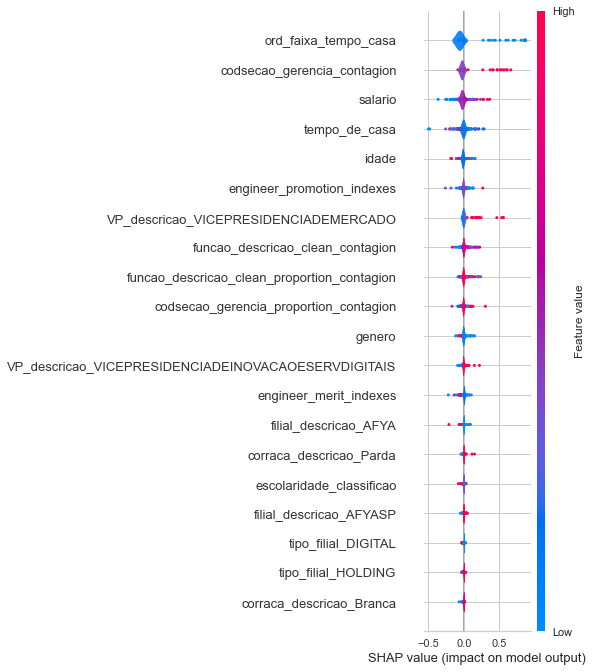

In [107]:
shap.summary_plot(shap_values, plot_type='violin')

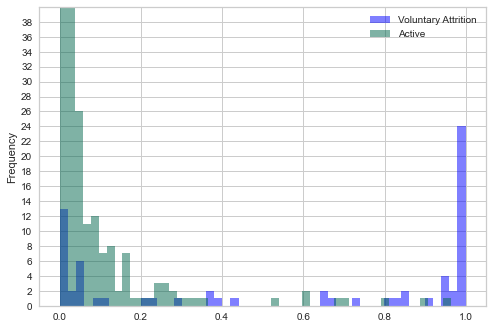

<AxesSubplot:ylabel='Frequency'>

In [109]:
X_test_analysis = X_test_final.copy()

X_test_analysis['pred_proba'] = xgb.predict_proba(X_test_final)[:, -1]

X_test_analysis['true'] = y_test

X_test_analysis = X_test_analysis.reset_index()

test = pd.DataFrame({'true': y_test, 'pred':xgb.predict_proba(X_test_final)[:, -1]})

limit = 40
bins = 50

test[test.true==1].pred.plot.hist(bins=bins, ylim=(0,limit), fc=(0, 0, 1, 0.5), legend='Legend', label='Voluntary Attrition', yticks=np.arange(0,limit,2))
test[test.true==0].pred.plot.hist(bins=bins, ylim=(0,limit), fc=(0, 0.4, 0.3, 0.5), legend='Legend', label='Active')

In [51]:
shap_analyze= pd.DataFrame()

index = 0

for i in shap_values:
    teste = pd.DataFrame(data=[list(i.values)], columns=X_test_final.columns, index=[index])
    shap_analyze = pd.concat([shap_analyze, teste])
    
    index += 1
    
    
shap_analyze

,tipo_filial_DIGITAL,VP_descricao_VICEPRESIDENCIADESERVICOSDIGITAIS,filial_descricao_AFYA,VP_descricao_VICEPRESIDENCIADEMERCADO,genero,VP_descricao_VICEPRESIDENCIADEINOVACAOESERVDIGITAIS,engineer_merit_indexes,codsecao_gerencia_contagion,salario,funcao_descricao_clean_contagion,tempo_de_casa,engineer_promotion_indexes
0,-0.00050,0.000000e+00,-0.00525,-0.00700,-0.01000,-0.00950,0.00550,-0.02975,-0.03625,-0.00450,-0.06300,-0.03975
1,0.00350,2.168404e-19,-0.00350,-0.00650,-0.00500,-0.00450,0.00725,-0.03725,-0.06625,0.00775,-0.15850,0.06300
2,0.00850,-7.500000e-04,-0.00075,-0.00525,0.00925,-0.00550,-0.08375,-0.03050,0.00100,-0.00925,-0.08550,0.00250
3,-0.04575,1.250000e-03,0.00175,-0.02000,-0.00900,0.00850,0.00675,-0.02650,-0.05050,-0.02550,-0.10600,0.06500
4,0.01525,1.500000e-03,-0.00950,-0.01950,-0.01700,-0.02000,0.01200,-0.02650,-0.09000,-0.02075,0.01050,-0.03600
...,...,...,...,...,...,...,...,...,...,...,...,...
437,-0.01800,-7.500000e-04,-0.00275,-0.01700,-0.01050,0.00575,0.00250,-0.04050,-0.02825,-0.00500,-0.13425,0.04875
438,-0.00225,-2.500000e-04,-0.00775,-0.00600,-0.02075,-0.00400,-0.00550,-0.04000,-0.13850,0.02925,0.04675,-0.05100
439,0.00025,-2.500000e-04,-0.01400,-0.01400,0.02750,-0.00775,0.01050,-0.01675,-0.22025,0.01525,0.07875,-0.05925
440,-0.00025,1.750000e-03,-0.00500,-0.01850,-0.01400,-0.01075,0.01225,-0.03925,-0.21675,0.04325,-0.03950,0.08675


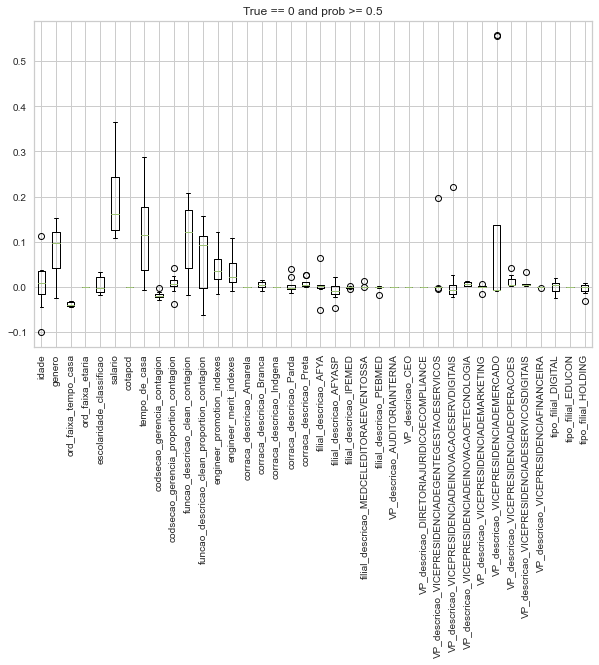

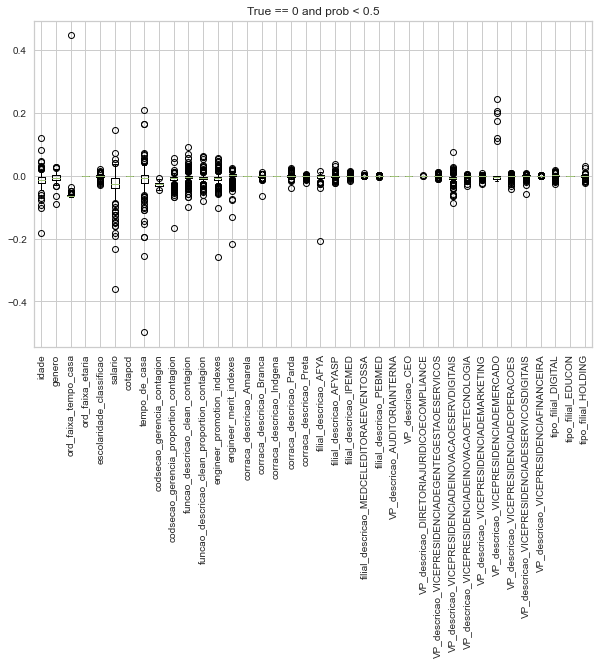

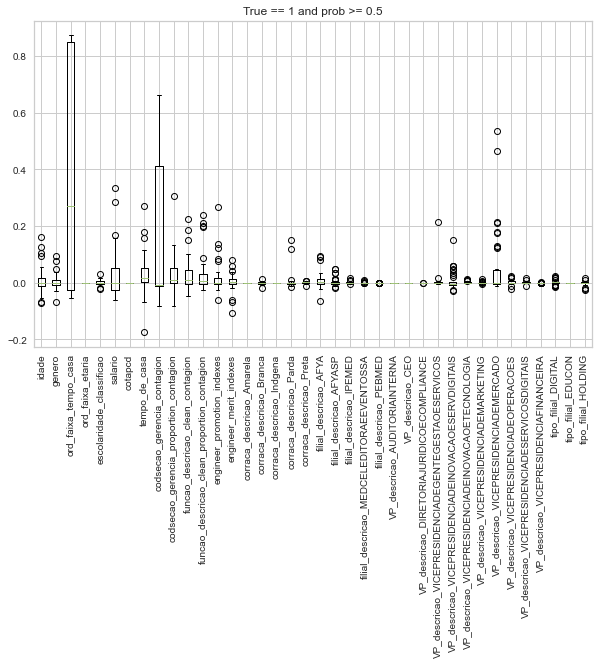

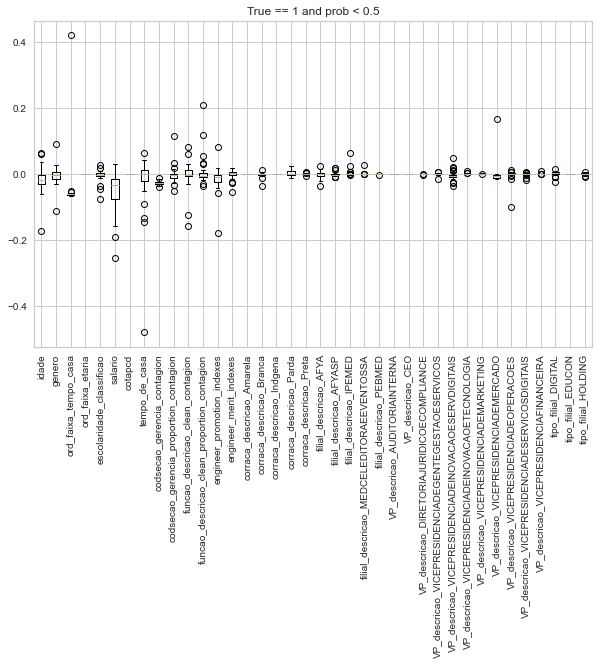

In [111]:
def plot_analysis(title='test', dictionary_analysis={}):
    
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.title(title)

    ax.boxplot(dictionary_analysis.values())
    ax.set_xticklabels(dictionary_analysis.keys(), rotation = 90);

for target_pred in range(0,2):
    
    index_analysis = X_test_analysis[(X_test_analysis.true == target_pred)&(X_test_analysis.pred_proba >= 0.5)].index
    
    shap_analyze_chosen = shap_analyze.iloc[index_analysis,:]
    
    shap_analyze_chosen_dict = {columns:shap_analyze_chosen[columns] for columns in shap_analyze_chosen}
    
    plot_analysis(f'True == {target_pred} and prob >= 0.5', shap_analyze_chosen_dict)
    
    index_analysis = X_test_analysis[(X_test_analysis.true == target_pred)&(X_test_analysis.pred_proba < 0.5)].index
    
    shap_analyze_chosen = shap_analyze.iloc[index_analysis,:]
    
    shap_analyze_chosen_dict = {columns:shap_analyze_chosen[columns] for columns in shap_analyze_chosen}
    
    plot_analysis(f'True == {target_pred} and prob < 0.5', shap_analyze_chosen_dict)

In [116]:
X_test_analysis_trat = X_test_analysis[['true']]

shap_final = pd.concat([shap_analyze, X_test_analysis_trat], axis=1  )

shap_final_trat = pd.melt(shap_final, id_vars=['true']).groupby(['true', 'variable']).median().reset_index()

index_true = shap_final_trat['true'] == 0

shap_final_trat.loc[index_true, 'value'] = shap_final_trat[index_true]*-1

shap_final_trat.loc[:, 'value'] = shap_final_trat.loc[:, 'value']*10

shap_final_trat = shap_final_trat.sort_values('value', ascending=False)

shap_final_trat = shap_final_trat.pivot(index='variable', columns='true')['value']

shap_final_trat = shap_final_trat.reindex()

shap_final_trat['dif'] = np.round(shap_final_trat[0] + shap_final_trat[1],3)

feature_shap_selection = shap_final_trat[shap_final_trat.dif != 0].sort_values('dif')

feature_shap_selection

true,0,1,dif
variable,,,
engineer_merit_indexes,-0.025000,1.666667e-02,-0.008
VP_descricao_VICEPRESIDENCIADEINOVACAOESERVDIGITAIS,0.058333,-5.000000e-02,0.008
corraca_descricao_Parda,0.016667,-8.333333e-03,0.008
corraca_descricao_Preta,-0.000000,8.333333e-03,0.008
filial_descricao_AFYA,-0.000000,8.333333e-03,0.008
VP_descricao_VICEPRESIDENCIADEMERCADO,0.041667,-2.500000e-02,0.017
engineer_promotion_indexes,0.075000,-4.166667e-02,0.033
funcao_descricao_clean_proportion_contagion,0.066667,-2.500000e-02,0.042
idade,0.141667,-1.000000e-01,0.042


In [124]:
a = ['tipo_filial_DIGITAL', 'filial_descricao_AFYA',
       'genero',
       'engineer_merit_indexes',
       'codsecao_gerencia_contagion',
       'salario', 'funcao_descricao_clean_contagion',
       'tempo_de_casa', 'engineer_promotion_indexes']

In [125]:
feature_shap_selection[feature_shap_selection.index.isin(a)]

true,0,1,dif
variable,,,
engineer_merit_indexes,-0.025000,1.666667e-02,-0.008
filial_descricao_AFYA,-0.000000,8.333333e-03,0.008
engineer_promotion_indexes,0.075000,-4.166667e-02,0.033
genero,0.066667,1.156482e-17,0.067
funcao_descricao_clean_contagion,0.033333,4.166667e-02,0.075
salario,0.266667,-1.833333e-01,0.083
codsecao_gerencia_contagion,0.275000,-1.583333e-01,0.117
tempo_de_casa,0.083333,8.333333e-02,0.167


In [ ]:
['tipo_filial_DIGITAL', 'VP_descricao_VICEPRESIDENCIADESERVICOSDIGITAIS',
       'filial_descricao_AFYA', 'VP_descricao_VICEPRESIDENCIADEMERCADO',
       'genero', 'corraca_descricao_Branca',
       'VP_descricao_VICEPRESIDENCIADEINOVACAOESERVDIGITAIS',
       'funcao_descricao_clean_proportion_contagion', 'engineer_merit_indexes',
       'codsecao_gerencia_proportion_contagion', 'codsecao_gerencia_contagion',
       'salario', 'funcao_descricao_clean_contagion', 'ord_faixa_tempo_casa',
       'tempo_de_casa', 'engineer_promotion_indexes']

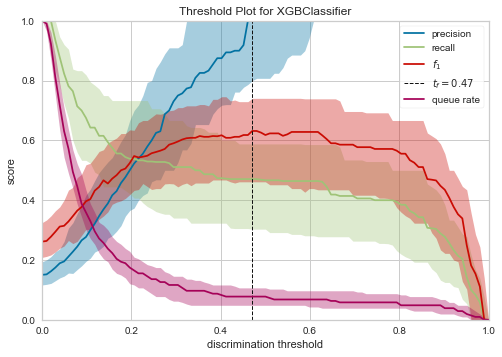

<AxesSubplot:title={'center':'Threshold Plot for XGBClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [138]:
from yellowbrick.classifier import DiscriminationThreshold


# Instantiate the classification model and visualizer
model = XGBClassifier(use_label_encoder=False, verbosity=0, **params)
visualizer = DiscriminationThreshold(model)

visualizer.fit(X_train_final, y_train_final)        # Fit the data to the visualizer
visualizer.show()           # Finalize and render the figure

MRXLinkPipelineError: Failed at component 'Validation Curve'.

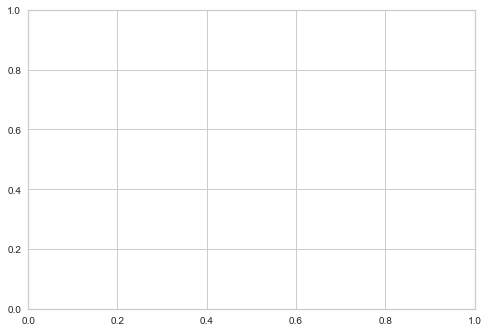

In [26]:
from yellowbrick.model_selection import validation_curve

viz = validation_curve(
    xgb, X_train_final, y_train_final,
    param_name= 'gamma',
    param_range= np.arange(1,7),
    cv=10, scoring='f1'
)

In [ ]:
index = 0
chosen_index = 0
last_best = 0


for i in visualizer.cv_scores_['precision'].tolist():
    
    if i > last_best:
        last_best = i
        chosen_index = index
        consecutive_better = 0
    else:
        consecutive_better += 1
        
    if consecutive_better > 9:
        break
        
    index += 1
        
print(str(last_best)+'/n'+ str(chosen_index))   

print(str(visualizer.thresholds_[chosen_index]))

In [140]:
X_dataset, y_dataset = X_optuna, y_optuna

model = xgb

evaluation = pd.DataFrame()

assertiveness = pd.DataFrame()

shf = ShuffleSplit(n_splits=100,test_size=0.3)

count = 0

for train_index, test_index in shf.split(X_dataset,y_dataset):

        X_train, y_train  = X_dataset.iloc[train_index].copy(), y_dataset.iloc[train_index].copy()
        X_test, y_test = X_dataset.iloc[test_index].copy(), y_dataset.iloc[test_index].copy()
        
        #Exclude if no oversample
        #X_train, y_train = over_under.fit_resample(X_train, y_train)

        model.fit(X_train,y_train)

        probabilities = [round(x,2) for x in model.predict_proba(X_test)[:,-1]]
        
        evaluation = pd.concat([evaluation, useful_metrics(X_test, y_test, model, threshold)],ignore_index=True)
        
        assertiveness_rec = pd.DataFrame({'index':X_test.index, 'probabilities': probabilities, 'y_true': y_test})
        
        assertiveness = pd.concat([assertiveness, assertiveness_rec])
        

        count+=1
        
        print("Shuffle " + str(count), end = "\r")
        
assertiveness['correct'] = assertiveness.y_true == (assertiveness.probabilities > threshold)
assertiveness['brier'] = abs(assertiveness.y_true - assertiveness.probabilities)
assertiveness['precision'] = [y if x ==0 else np.nan for x,y in zip(assertiveness.y_true,assertiveness.correct)]
assertiveness['recall'] = [y if x ==1 else np.nan for x,y in zip(assertiveness.y_true,assertiveness.correct)]
        
grouped_stats = assertiveness.groupby('index').agg(
        avg_correct_percent =('correct', 'mean'),
        avg_precision = ('precision', np.nanmean),
        avg_recall = ('recall', np.nanmean),
        std = ('brier', np.std),
        brier = ('brier', np.mean),
        count = ('brier', 'count')
        )
        
X_dataset_stats = pd.merge(X_dataset,grouped_stats, left_index=True, right_index=True)

X_dataset_stats = pd.merge(X_dataset_stats,pd.get_dummies(y_dataset, prefix='target'), left_index=True, right_index=True)


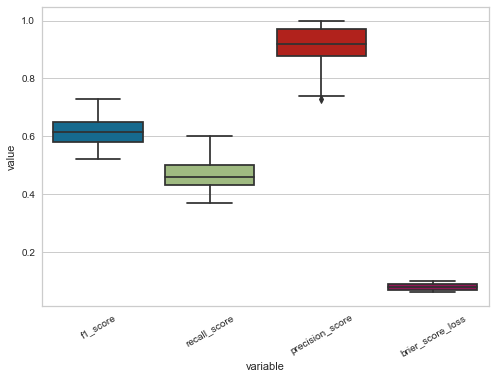

[Text(0, 0, 'f1_score'),
 Text(1, 0, 'recall_score'),
 Text(2, 0, 'precision_score'),
 Text(3, 0, 'brier_score_loss')]

In [141]:
duration = 1000  # milliseconds
freq = 440# Hz
winsound.Beep(freq, duration)
ax = sns.boxplot(x='variable', y='value', data=pd.melt(evaluation))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30);

In [ ]:
X_holdout_final = final_transformation(X_holdout,feature_final, 0, 'N')

In [142]:
xgb.fit(X_optuna, y_optuna)

metrics_final = useful_metrics(X_holdout_final, y_holdout, xgb, threshold)

confusion_matrix = metrics.confusion_matrix(
    y_holdout, xgb.predict_proba(X_holdout_final)[:, -1] > threshold)

tn, fp, fn, tp = confusion_matrix.ravel()
specificity = tn / (tn+fp)

<AxesSubplot:ylabel='Frequency'>

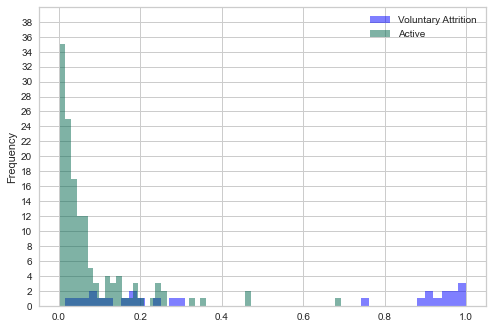

In [143]:
test = pd.DataFrame({'true': y_holdout, 'pred':xgb.predict_proba(X_holdout_final)[:, -1]})

limit = 40
bins = 50

test[test.true==1].pred.plot.hist(bins=bins, ylim=(0,limit), fc=(0, 0, 1, 0.5), legend='Legend', label='Voluntary Attrition', yticks=np.arange(0,limit,2))
test[test.true==0].pred.plot.hist(bins=bins, ylim=(0,limit), fc=(0, 0.4, 0.3, 0.5), legend='Legend', label='Active')

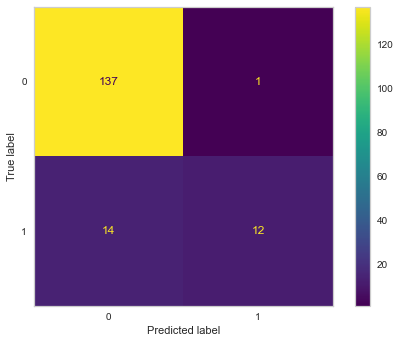

In [146]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)

cm_display.plot()
plt.grid(False)
plt.show()

In [150]:
print(f"O teste final do modelo conseguiu capturar {round(metrics_final['recall_score'][0]*100,2)}% ({tp} pessoa(s)) que iriam sair.\n")

print(f'O custo desse tipo de predição foi de {round(100-specificity*100,1)}%.\n Resumindo, o modelo previu que {fp} pessoa(s) da base iria sair, mas não saiu...')

print('\nExcelente notícia!!!!')



duration = 1000  # milliseconds
freq = 440  # Hz
winsound.Beep(freq, duration)


O teste final do modelo conseguiu capturar 46.0% (12 pessoa(s)) que iriam sair.
    
O custo desse tipo de predição foi de 0.7%.
     Resumindo, o modelo previu que 1 pessoa(s) da base iria sair, mas não saiu...

    Excelente notícia!!!!


In [152]:
dump(xgb, open('turnover_general_model.pkl', 'wb'))

dump(threshold, open('threshold.pkl', 'wb'))